In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import tweepy
import pickle
import plotnine
from plotnine import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

## function to load credentials file
def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

# 0. Setup: authenticate to Twitter API

In [2]:
## read creds file- replace with path to your creds
creds = load_creds("../../../cred.yml")


In [3]:
## use bearer token to initialize a tweepy client (connection with twitter API)
client = tweepy.Client(bearer_token= creds['twitter_api']['bearer_token'])

## print type
print(type(client))

<class 'tweepy.client.Client'>


# 1. Use one: pulling recent tweets associated with a hashtag

Here, we're going to pull recent tweets associated with the metoo hashtag. Note that if we want tweets older than a week, we need to either get an academic license (rather than a student one) or use another method (discussion here: https://stackoverflow.com/questions/24214189/how-can-i-get-tweets-older-than-a-week-using-tweepy-or-other-python-libraries) 

The `Cursor` class w/in tweepy allows us to pull while skipping annoying things like pagination

**Example use**: Gallagher et al. look at the use of hashtags #BlackLivesMatter, #AllLivesMatters, and others in days following instances of officer-involved shootings or indictments/non-indictments. They examine things like the different words that are used in tweets containing those hashtags and whether the conversations occur separately or whether those using the #AllLivesMatter hashtag are inserting themselves into BLM conversations: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195644

## 1.1 Printing tweets and their attributes

In [4]:
## construct a hashtag
## we're filtering out retweets for simplicity
## discussion here of query construction:
## https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
query = "#metoo econ -@jenniferagerson -is:retweet"

tweets_mt = client.search_recent_tweets(query = query, max_results = 100,
                                    tweet_fields = ['created_at',
                                                    'author_id',
                                                   'geo',
                                                   'lang', 
                                                   'public_metrics'],
                                    user_fields = ['description',
                                                  'location',
                                                  'verified',
                                                  'public_metrics'],
                                    expansions = 'author_id',
                                    end_time = "2022-10-30T01:00:00-00:00")



In [5]:
single_tweet = tweets_mt.data[0]
single_tweet

single_tweet.lang
single_tweet.public_metrics

print(type(single_tweet))

print(type(tweets_mt))

print(type(tweets_mt.data))

tweets_mt.data[0:10]

<Tweet id=1586443928307236864 text=Great article connecting status hierarchies and elitism in econ to #metoo and institutional tolerance of harassment in historical perspective. https://t.co/z5w8pJZmVA>

'en'

{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}

<class 'tweepy.tweet.Tweet'>
<class 'tweepy.client.Response'>
<class 'list'>


[<Tweet id=1586443928307236864 text=Great article connecting status hierarchies and elitism in econ to #metoo and institutional tolerance of harassment in historical perspective. https://t.co/z5w8pJZmVA>,
 <Tweet id=1585557668776779778 text=There is a large #MeToo moment taking place in Economics.
 To all men who react to this with "I can't believe it, I am so shocked": where have you been the past 5 years?
 To all men in political science who say "that's econ, not us": where have you been the past 5 years? https://t.co/tvIYfkjtzg>,
 <Tweet id=1585388157352431616 text=Doleac storming #EconTwitter to take down few  Econ creeps is a feat of formidable, reckless courage! I’m impressed that she calls out these creeps by name, since I know what can happen to those taking the social media &amp; press #MeToo route! respect 🙌🏻 to Doleac for doing this! https://t.co/YHZzGNqZnG>,
 <Tweet id=1585363830976045056 text=I'm finding the #metoo in Econ movement to be interesting from a legal/compliance

In [6]:
## attributes of the tweet
### iterating over the list of tweets
### and for each tweet, pulling some info (just printing first 5)
tweet_res = [print("""On {}, {} tweeted {} in {} language, which was liked by {}
    """.format(tweet.created_at,
              tweet.author_id,
              tweet.text,
              tweet.lang,
              tweet.public_metrics['like_count'],
              tweet.public_metrics['retweet_count']))
for tweet in tweets_mt.data[0:5]]



manual_data = pd.DataFrame({'author_id': [tweet.author_id for tweet in tweets_mt.data],
                           'text': [tweet.text for tweet in tweets_mt.data],
                           })

On 2022-10-29 19:44:41+00:00, 1490757508708900875 tweeted Great article connecting status hierarchies and elitism in econ to #metoo and institutional tolerance of harassment in historical perspective. https://t.co/z5w8pJZmVA in en language, which was liked by 0
    
On 2022-10-27 09:03:01+00:00, 725686324662046724 tweeted There is a large #MeToo moment taking place in Economics.
To all men who react to this with "I can't believe it, I am so shocked": where have you been the past 5 years?
To all men in political science who say "that's econ, not us": where have you been the past 5 years? https://t.co/tvIYfkjtzg in en language, which was liked by 237
    
On 2022-10-26 21:49:26+00:00, 3067027552 tweeted Doleac storming #EconTwitter to take down few  Econ creeps is a feat of formidable, reckless courage! I’m impressed that she calls out these creeps by name, since I know what can happen to those taking the social media &amp; press #MeToo route! respect 🙌🏻 to Doleac for doing this! https:/

## 1.2 Printing attributes of users 

In [7]:
## add attributes of the user
users = {user["id"]: user for user in tweets_mt.includes['users']}
#users
### similarly, iterating over the list of tweets
### and for each tweet, finding its author id and 
### printing some info
for tweet in tweets_mt.data[0:5]:
    u_info = users[tweet.author_id]
    print("""On {}, {}, whose verification status is: {}
    and follower count is: {}
    tweeted: {}
    """.format(tweet.created_at,
              u_info.username,
              u_info.verified,
            u_info.public_metrics['followers_count'],
            tweet.text))

On 2022-10-29 19:44:41+00:00, edo_navot, whose verification status is: False
    and follower count is: 85
    tweeted: Great article connecting status hierarchies and elitism in econ to #metoo and institutional tolerance of harassment in historical perspective. https://t.co/z5w8pJZmVA
    
On 2022-10-27 09:03:01+00:00, tabouchadi, whose verification status is: True
    and follower count is: 19276
    tweeted: There is a large #MeToo moment taking place in Economics.
To all men who react to this with "I can't believe it, I am so shocked": where have you been the past 5 years?
To all men in political science who say "that's econ, not us": where have you been the past 5 years? https://t.co/tvIYfkjtzg
    
On 2022-10-26 21:49:26+00:00, anarkriminology, whose verification status is: False
    and follower count is: 1744
    tweeted: Doleac storming #EconTwitter to take down few  Econ creeps is a feat of formidable, reckless courage! I’m impressed that she calls out these creeps by name, s

## 1.3 Storing that tweet and user information in a dataframe

If we want to work with this as data, instead of iterating and printing, 
want to store in a dataframe

### 1.3.1 Pull attributes/metadata about tweets

In [8]:

### define the attributes (need to be pulled
### in the search_recent_tweets call above)
tweet_attr = ['id',
              'created_at', 'author_id', 
             'text', 'lang', 'geo', 'public_metrics']


### function to iterate over attributes
def pull_attr(one_tweet, which_attr):
    all_attr = [one_tweet[attr] if attr != 'public_metrics'
                else 
                one_tweet[attr]['like_count']
                for attr in which_attr]
    return(all_attr)

### iterate over tweets and pull tweet info
tweets_info_list = [pull_attr(one_tweet, tweet_attr)
              for one_tweet in tweets_mt.data]

print(type(tweets_info_list))

tweets_info_list[0:3]

<class 'list'>


[[1586443928307236864,
  datetime.datetime(2022, 10, 29, 19, 44, 41, tzinfo=datetime.timezone.utc),
  1490757508708900875,
  'Great article connecting status hierarchies and elitism in econ to #metoo and institutional tolerance of harassment in historical perspective. https://t.co/z5w8pJZmVA',
  'en',
  None,
  0],
 [1585557668776779778,
  datetime.datetime(2022, 10, 27, 9, 3, 1, tzinfo=datetime.timezone.utc),
  725686324662046724,
  'There is a large #MeToo moment taking place in Economics.\nTo all men who react to this with "I can\'t believe it, I am so shocked": where have you been the past 5 years?\nTo all men in political science who say "that\'s econ, not us": where have you been the past 5 years? https://t.co/tvIYfkjtzg',
  'en',
  None,
  237],
 [1585388157352431616,
  datetime.datetime(2022, 10, 26, 21, 49, 26, tzinfo=datetime.timezone.utc),
  3067027552,
  'Doleac storming #EconTwitter to take down few  Econ creeps is a feat of formidable, reckless courage! I’m impressed that

In [9]:
### transform into a dataframe
tweets_info_df = pd.DataFrame(tweets_info_list,
                                columns = tweet_attr)

tweets_info_df[tweets_info_df.lang == "en"].sort_values(by = 'public_metrics', 
                           ascending = False).head()


,id,created_at,author_id,text,lang,geo,public_metrics
1,1585557668776779778,2022-10-27 09:03:01+00:00,725686324662046724,"There is a large #MeToo moment taking place in Economics.\nTo all men who react to this with ""I can't believe it, I am so shocked"": where have you been the past 5 years?\nTo all men in political science who say ""that's econ, not us"": where have you been the past 5 years? https://t.co/tvIYfkjtzg",en,None,237
5,1585239900961374208,2022-10-26 12:00:19+00:00,482431084,"It's hard to overstate how important econ's latest #MeToo events are.\n\nTo be its best, the field needs everyone, which means welcoming and protecting every economist or potential economist.\n\nI've mostly been listening but have two thoughts to emphasize:",en,None,149
13,1584721962823479297,2022-10-25 01:42:13+00:00,64092459,the #metoo (second season) moment in Econ has been SUPER useful in building my block list,en,None,121
18,1584590533489414144,2022-10-24 16:59:58+00:00,242422673,"If anyone has anything to say regarding the ongoing #metoo in econ, I can put u in touch with very professional investigative journalist that reached out to me. They can protect your identity and are open to chat on signal/telegram etc. They have long experience with this stuff",en,{'place_id': '2260fcb4a77f2bad'},65
14,1584654525717413889,2022-10-24 21:14:15+00:00,245987858,"Plus, it highlights how important these statements are…signaling what the culture in Econ is currently like, moving towards, etc. The ripple effects can be massive! #EconTwitter #MeToo \n(3/4)",en,None,47


### 1.3.2 Pull attributes/metadata about users

In [10]:
### define the user attributes (similarly need to be pulled)
user_attr = ['username', 'description',
             'location', 'verified', 'public_metrics']

### function to iterate over user attributes
def pull_user_attr(one_tweet, which_attr):
    
    one_user = users[one_tweet.author_id]
    all_attr = [one_tweet.author_id] + \
                [one_user[attr] 
                if 
                attr != "public_metrics"
                else 
                one_user[attr]['followers_count']
                for attr in which_attr] 
    return(all_attr)

### iterate over tweets and pull user info
users_info_list = [pull_user_attr(one_tweet, user_attr)
                    for one_tweet 
                    in tweets_mt.data]


user_info_df = pd.DataFrame(users_info_list,
                               columns = ['author_id'] + user_attr)

user_info_df.head()

,author_id,username,description,location,verified,public_metrics
0,1490757508708900875,edo_navot,"Sociologist @UF & economist @USDOL 🤷‍♂️. Discrimination, inequality, labor, stratification. One foot in heterodox econ. Dad of 4. Personal account.",None,False,85
1,725686324662046724,tabouchadi,"Associate Professor in European Politics at Nuffield College, University of Oxford. Elections, parties, social democracy & the radical right. he/him. 🏳️‍🌈",None,True,19276
2,3067027552,anarkriminology,"Badass Criminologist: Courts, reentry, anti-trafficking. I escaped sex trafficking; went back to liberate others. Doctoral Student Sociology/Criminology",New York,False,1744
3,1103291589433196545,VRootMartinez,"Personal account. She/Her. Tweets Delete.\n\nProf. @DukeLaw studying Ethics, Compliance & Inclusion\n\nScholarship - https://t.co/vZpTUAbUBi","Durham, NC",False,3371
4,800742266826461184,O_Goss_,Alumn @ENS_ULM - Senior scientist @cnrs @CrestUmr - Econ Prof @Polytechnique @XDepEco - Maths Prof @LSEMaths - All remaining errors are mine,"Paris, France",False,1754


In [11]:
## merge on author id so that we have
## metadata on both tweets and users
tweets_df = pd.merge(tweets_info_df,
                    user_info_df,
                    on = 'author_id',
                    how = 'left',
                    suffixes = ['_tweet', '_user']).drop_duplicates(subset = 'id')

tweets_df.loc[tweets_df.lang == "en",
             ['text', 'public_metrics_tweet',
             'username', 'description', 
             'public_metrics_user']].sort_values(by = 'public_metrics_tweet', 
                            ascending = False).head()

,text,public_metrics_tweet,username,description,public_metrics_user
1,"There is a large #MeToo moment taking place in Economics.\nTo all men who react to this with ""I can't believe it, I am so shocked"": where have you been the past 5 years?\nTo all men in political science who say ""that's econ, not us"": where have you been the past 5 years? https://t.co/tvIYfkjtzg",237,tabouchadi,"Associate Professor in European Politics at Nuffield College, University of Oxford. Elections, parties, social democracy & the radical right. he/him. 🏳️‍🌈",19276
5,"It's hard to overstate how important econ's latest #MeToo events are.\n\nTo be its best, the field needs everyone, which means welcoming and protecting every economist or potential economist.\n\nI've mostly been listening but have two thoughts to emphasize:",149,JoshuaSGoodman,Education/labor economist - @WhiteHouseCEA (2022-23) - @BUWheelock / @BU_Economics - @Wheelock_Policy - @JPAM_DC,17499
13,the #metoo (second season) moment in Econ has been SUPER useful in building my block list,121,dynarski,economist | inequality & education | 1st-gen | prof @Harvard | @americanacad @NAEduc NBER | columns @nytimes https://t.co/5RZ12LOAPB | @dynarski@mastodon.social,44231
18,"If anyone has anything to say regarding the ongoing #metoo in econ, I can put u in touch with very professional investigative journalist that reached out to me. They can protect your identity and are open to chat on signal/telegram etc. They have long experience with this stuff",65,dorotheafrenkel,"Assistant Prof in Behavioral Econ @TheChoiceLab examining the role of gender in group work, reproducibility & other topics.atm: TEACHING. 🇸🇪✡️🇭🇺",4154
14,"Plus, it highlights how important these statements are…signaling what the culture in Econ is currently like, moving towards, etc. The ripple effects can be massive! #EconTwitter #MeToo \n(3/4)",47,estebanjq3,"Development economist, demographer & social scientist @MathematicaNow prior @UW_AAE @UW_CDE @IFPRI @FAO @AmeriCorpsNCCC Anti-fascist Anti-racist he/el 🇺🇸🇪🇨",2470


## 1.4 Exploring the results

In [12]:
### 1. what percent are diff languages?
tweets_df.lang.value_counts(normalize = True)

en     0.875000
fa     0.041667
es     0.041667
qme    0.041667
Name: lang, dtype: float64

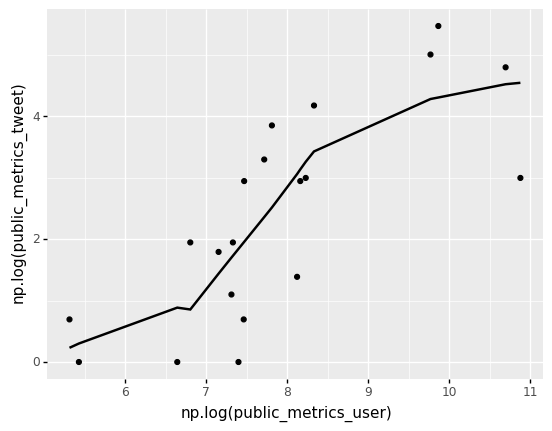

<ggplot: (8774595960622)>

In [13]:
### 2. what's the relationship b/t followers and likes? (logged and removing 0)
(ggplot(tweets_df[(tweets_df.public_metrics_user > 0) &
                  (tweets_df.public_metrics_tweet > 0)], 
                  aes(x = 'np.log(public_metrics_user)', 
                    y = 'np.log(public_metrics_tweet)')) +
geom_point() +
geom_smooth(method = "lowess", se = False))


In [14]:
### 3. search for who's tagged in a tweet - restricting to english language
tag_pat = r".*(@\w+).*"
### iterate over tweets
all_tags = [re.findall(tag_pat, one_tweet) 
            for one_tweet in tweets_df.text[tweets_df.lang == "en"]
           if len(re.findall(tag_pat, one_tweet)) > 0]
### flatten list to count repeats and summarize top
all_tags_onelist = [item for sublist in all_tags for item in sublist]
pd.Series(all_tags_onelist).value_counts()



@ErikaMcentarfer    1
@top20              1
@USydneyEcon        1
@briq_institute     1
dtype: int64

In [15]:
### 4. search for hashtags in a tweet
hash_pat = r".*(\#\w+)\s+.*"
### iterate over tweets
all_hasht = [re.findall(hash_pat, one_tweet) 
            for one_tweet in tweets_df.text
           if len(re.findall(hash_pat, one_tweet)) > 0]

### flatten list to count repeats and summarize top
all_hash_onelist = [item for sublist in all_hasht for item in sublist]
pd.Series(all_hash_onelist).value_counts()

#metoo          11
#MeToo           9
#MeTooEcon       1
#EconTwitter     1
dtype: int64

In [16]:
SAVE_BACKUP = False
if SAVE_BACKUP:
    tweets_df.to_pickle("../../../public_data/tweets_f22.pkl")

# 2. Use two: examining relationships between those on the site

- Previous example showed both who tweeted with a lot of likes/high follower counts, and also who they tended to tag in the tweets
- We can also use twitter to form the start of a social network where nodes are different accounts and edges are drawn between followers who follow the same focal account; here, we'll look at a simplified form

**Example use**: Mosleh et al. do a field experiment where they create Twitter bots that either self-identify as Republican or Democrat and then the bots follow people. They look at how the partisanship of the user the bot follows predicts whether the user follows a bot back: https://www.pnas.org/content/118/7/e2022761118.short

In [17]:
## choose a focal account from above
READ_SAVED = True
if READ_SAVED:
    tweets_df = pd.read_pickle("../../../public_data/tweets_f22.pkl")
tweets_df.sort_values(by = 'public_metrics_tweet', ascending = False).head()




,id,created_at,author_id,text,lang,geo,public_metrics_tweet,username,description,location,verified,public_metrics_user
1,1585557668776779778,2022-10-27 09:03:01+00:00,725686324662046724,"There is a large #MeToo moment taking place in Economics.\nTo all men who react to this with ""I can't believe it, I am so shocked"": where have you been the past 5 years?\nTo all men in political science who say ""that's econ, not us"": where have you been the past 5 years? https://t.co/tvIYfkjtzg",en,None,237,tabouchadi,"Associate Professor in European Politics at Nuffield College, University of Oxford. Elections, parties, social democracy & the radical right. he/him. 🏳️‍🌈",None,True,19276
5,1585239900961374208,2022-10-26 12:00:19+00:00,482431084,"It's hard to overstate how important econ's latest #MeToo events are.\n\nTo be its best, the field needs everyone, which means welcoming and protecting every economist or potential economist.\n\nI've mostly been listening but have two thoughts to emphasize:",en,None,149,JoshuaSGoodman,Education/labor economist - @WhiteHouseCEA (2022-23) - @BUWheelock / @BU_Economics - @Wheelock_Policy - @JPAM_DC,"Cambridge, MA",False,17499
13,1584721962823479297,2022-10-25 01:42:13+00:00,64092459,the #metoo (second season) moment in Econ has been SUPER useful in building my block list,en,None,121,dynarski,economist | inequality & education | 1st-gen | prof @Harvard | @americanacad @NAEduc NBER | columns @nytimes https://t.co/5RZ12LOAPB | @dynarski@mastodon.social,Cambridge via Somerville,True,44231
18,1584590533489414144,2022-10-24 16:59:58+00:00,242422673,"If anyone has anything to say regarding the ongoing #metoo in econ, I can put u in touch with very professional investigative journalist that reached out to me. They can protect your identity and are open to chat on signal/telegram etc. They have long experience with this stuff",en,{'place_id': '2260fcb4a77f2bad'},65,dorotheafrenkel,"Assistant Prof in Behavioral Econ @TheChoiceLab examining the role of gender in group work, reproducibility & other topics.atm: TEACHING. 🇸🇪✡️🇭🇺","Bergen, Norway",False,4154
14,1584654525717413889,2022-10-24 21:14:15+00:00,245987858,"Plus, it highlights how important these statements are…signaling what the culture in Econ is currently like, moving towards, etc. The ripple effects can be massive! #EconTwitter #MeToo \n(3/4)",en,None,47,estebanjq3,"Development economist, demographer & social scientist @MathematicaNow prior @UW_AAE @UW_CDE @IFPRI @FAO @AmeriCorpsNCCC Anti-fascist Anti-racist he/el 🇺🇸🇪🇨","Chicagoland, IL",False,2470


In [18]:


focal_acc_row = tweets_df[tweets_df.username.str.contains("JoshuaSGoodman")]
focal_acc_id = focal_acc_row.author_id.iloc[0]

## can also get their id based on username
focal_acc_id_alt = client.get_user(username = "JoshuaSGoodman").data['id']

assert focal_acc_id == focal_acc_id_alt

In [19]:
## pull user followers (defaults to most recent 100 followers)
follow_focal = client.get_users_followers(id = focal_acc_id,
                                         user_fields = user_attr)

print(type(follow_focal))
len(follow_focal.data)

## get data - this time more manually rather than function
user_data = pd.DataFrame({'uname': [user['username'] for user in follow_focal.data],
                          'description': [user['description'] for user in follow_focal.data],
                          'user_id': [user['id'] for user in follow_focal.data],
                         'followers': [user['public_metrics']['followers_count'] 
                                        for user in follow_focal.data]})
user_data.sort_values(by = 'followers', ascending = False)



<class 'tweepy.client.Response'>


100

,uname,description,user_id,followers
55,pdacosta,"Federal Reserve Correspondent & Head of Policy for the Americas at @MNIMarketNews. Host, #FedSpeak podcast. Previously: @Reuters, @WSJ, @PIIE. Opinions my own.",65466158,138958
5,MichaelLaRosaDC,"Managing Director, @Pentagrp | Former @WhiteHouse @FLOTUS Press Sec | 2020 @DrBiden Spox | @HouseDPCC @SenatorCantwell Comms Dir | 📺TV Producer @HardballChris",269314519,18240
85,naderi_yeganeh,Research Student @UCL Maths. Mathematical artist.\n\nEmail: naderiyeganeh at gmail dot com,3900026412,11377
49,drjenndowd,"Prof. Demography & Population Health @UniofOxford @OxfordDemSci. Mortality, Epidemiology, Infections/Immunity, COVID-19. 🇺🇸 in 🇬🇧.Nerdy Girl @DearPandemic",18089975,8055
14,eyyuptoksoyy,Scientist–Medical Biotechnology and Bionanotechnology–Medical nanomaterials science / I am trying to improve the quality of life of humanity.,1487043784248594435,7058
...,...,...,...,...
18,pratapkumiyal,student of DSB \ncampus nainital\n(M.A ECONOMICS),1585985991428345856,1
93,MontyNoble7,,1428726389599997953,0
12,xianlitijun233,,1525844983332282368,0
9,Jerry22976974,,1241721436420612096,0


In [20]:
## can then see who are followers of followers
follow_top_row = user_data[user_data.followers == np.max(user_data.followers)]
follow_top_id = follow_top_row.user_id.iloc[0]


In [21]:
## similarly, get followers and view them (would probably want to write function at this point)
follow_degree2 = client.get_users_followers(id = follow_top_id,
                                         user_fields = user_attr)
user_data_degree2 = pd.DataFrame({'uname': [user['username'] for user in follow_degree2.data],
                          'description': [user['description'] for user in follow_degree2.data],
                          'user_id': [user['id'] for user in follow_degree2.data],
                         'followers': [user['public_metrics']['followers_count'] for user in follow_degree2.data]})
user_data_degree2.sort_values(by = 'followers', ascending = False)

,uname,description,user_id,followers
2,BrettHarrison88,"Advisor @FTX_Official; previously President of FTX US, algorithmic trading systems @JaneStreetGroup and @citsecurities",1392369347247710218,56718
65,Galt___,🎸🎹🎸🎨🖌📈🦍🚀 https://t.co/grbcueyDXC,59893694,6493
11,JabburrP,Award winning affiliate marketing program with recurring income for 5 years . Services that people and business use repeatedly. Get paid same day as sales.,1451117775414562816,4341
87,DOPECHICKBEATS,Emmy Award Winning Producer/Audio Engineer. Unapologetically Black. My tweets are my own. Proudly displaying my Black Girl Magic💁🏾‍♀️,311490088,3867
23,_Lisa_Murray,Pursuing Peace...Lisa Murray\nMarriage & Family Therapist. Equipping individuals to discover spiritual + emotional + relational wellbeing! #peaceforalifetime,2496928968,3506
...,...,...,...,...
13,tigerskyla,,1243706441573101569,0
92,aarodsr,,837740053,0
60,W_Jane2022,,1585559651780890624,0
51,DayleGrizzell,,1586139951909019649,0


# Use three: extract recent tweets from a specific user

If we have a dataset or panel of users, can get their tweets and extract properties like likes, retweets, etc (most recent ~3200)

**Example use**: Bisbee et al. construct a panel of political science professors use Twitter; they then follow those users and looks at who retweets each other's research, finding that male professors are more likely to pass on research by other male professors than by female professors - https://www.cambridge.org/core/journals/perspectives-on-politics/article/polisci-twitter-a-descriptive-analysis-of-how-political-scientists-use-twitter-in-2019/C8A193C3E939C1ABCD4600DFE8AEF79A

In [22]:
## step 1: choose a focal account and get their numeric id
focal_account = "McCourtSchool"
get_id = client.get_user(username= focal_account, user_fields = user_attr)
m_id = get_id.data['id']

## step 2: use the get_users_tweets method to 
## pull recent tweets - here, i'm pulling most recent 100
m_tweets_resp = client.get_users_tweets(id = m_id,
                                       max_results = 100, 
                                       tweet_fields = tweet_attr)

## step 3: that returns a response with data as an attribute
## to turn into a dataframe, use function above 
m_tweets_list = [pull_attr(one_tweet, tweet_attr)
                      for one_tweet in m_tweets_resp.data]

### step 4: transform into a dataframe
m_tweets_df = pd.DataFrame(m_tweets_list,
                                columns = tweet_attr)
m_tweets_df.head()

,id,created_at,author_id,text,lang,geo,public_metrics
0,1586072858064990208,2022-10-28 19:10:11+00:00,1101377533,"Last month McCourt School students, faculty and staff joined the @McCourtInst, Project Liberty and several other partner organizations for @byUnfinished Live. Check out this recap of their experiences: https://t.co/TcERAJ0WRX",en,None,2
1,1586058714502418433,2022-10-28 18:13:59+00:00,1101377533,On November 1 at 4:00 PM join us in Old North 205 for our annual Whittington Lecture featuring @CeciliaERouse speaking about “Rebuilding Our Economy: How Government Can Help Lay the Foundation for Economic Growth.” RSVP today: https://t.co/bXcxEyuEib,en,None,1
2,1586053124951003136,2022-10-28 17:51:47+00:00,1101377533,"RT @gutechpolicy: ""What is the internet? How does infrastructure associate with power?"" Thank you to @LauraDeNardis and @EmilyTav for an in…",en,None,0
3,1585681228434243584,2022-10-27 17:14:00+00:00,1101377533,"JOIN US NEXT WEEK for our annual Whittington Lecture featuring @CeciliaERouse speaking about ""How Government Can Help Lay the Foundation for Economic Growth."" RSVP today: https://t.co/bXcxEyuEib",en,None,2
4,1585661580888354816,2022-10-27 15:55:55+00:00,1101377533,We are going as the Iowa Caucus - what about you? https://t.co/sJ3OCw1Wh3,en,None,1


In [23]:
## do sentiment scoring on the tweet
si_scorer = SentimentIntensityAnalyzer()
m_tweets_df['compound_sent'] = [si_scorer.polarity_scores(one_tweet)['compound'] 
                                      for one_tweet in m_tweets_df.text]
m_tweets_df.sort_values(by = 'compound_sent', ascending = False).head(5)
m_tweets_df.sort_values(by = 'compound_sent', ascending = False).tail(5)



,id,created_at,author_id,text,lang,geo,public_metrics,compound_sent
24,1584881642006777856,2022-10-25 12:16:43+00:00,1101377533,"Happy Diwali to all who celebrate! We hope your day was full of light, laughter, and celebrations 🎆🎇🪔 https://t.co/zxxFRA4Lq1",en,None,0,0.9299
40,1582781623023505409,2022-10-19 17:12:00+00:00,1101377533,@MassiveData_GU was awarded a @ssrc_org grant for their project helping to generate awareness and discussion of methods to better measure the diverse U.S. population. Congratulations @amy__ohara and fellow GU researchers! https://t.co/0zFOyXLhcs,en,None,3,0.9259
41,1582774073255403521,2022-10-19 16:42:00+00:00,1101377533,"Please join us in congratulating this year's McCourt Scholar, Brooke LePage (MPP-E’23)! Brooke is passionate about gender justice and committed to dismantling harmful gender norms for the next generation. https://t.co/9UkV2omlZI",en,None,5,0.9134
12,1585326364558733312,2022-10-26 17:43:53+00:00,1101377533,Are you interested in learning more about what it is like to be an advisor to the President of the United States? Join us on November 1 at 4:00 PM for our annual Whittington Lecture featuring @CeciliaERouse! RSVP today: https://t.co/Na1rqoaAl0,en,None,2,0.8588
97,1579508675055869952,2022-10-10 16:26:28+00:00,1101377533,"RT @Georgetown: Wishing Georgetown's Jewish community and all who celebrate, prosperity, abundance, and joy this Sukkot. https://t.co/wcA6g…",en,None,0,0.8555


,id,created_at,author_id,text,lang,geo,public_metrics,compound_sent
11,1585327055629348864,2022-10-26 17:46:38+00:00,1101377533,"RT @GeorgetownFaith: Tonight's the night for our conversation on the dangers of White Christian Nationalism, with @PB_Curry of @iamepiscopa…",en,None,0,-0.4939
19,1584935926647599104,2022-10-25 15:52:26+00:00,1101377533,The McCourt School is saddened to learn of the passing of Professor Pablo Eisenberg. Our thoughts are with his loved ones as they mourn his loss.,en,None,0,-0.5574
10,1585327674595033089,2022-10-26 17:49:06+00:00,1101377533,"RT @gtownlibrary: New on the Library's webpage is a series of DEI resources, with information about race, racism, and antiracism; microaggr…",en,None,0,-0.6249
51,1582016330546311169,2022-10-17 14:31:00+00:00,1101377533,"“When bad things happen, there’s going to be a lot of pressure for the military to fix everything that public policy can’t fix.” - @JulietteKayyem at a recent event with McCourt School students https://t.co/w9cXRlIdjs",en,None,8,-0.6908
5,1585660543544664064,2022-10-27 15:51:48+00:00,1101377533,Women of color running for office face 4x higher rates of violent threats online. A critical new report by @CenDemTech highlights this issue &amp; calls for action to address it. https://t.co/le6f1ZfRRk,en,None,2,-0.8402


/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


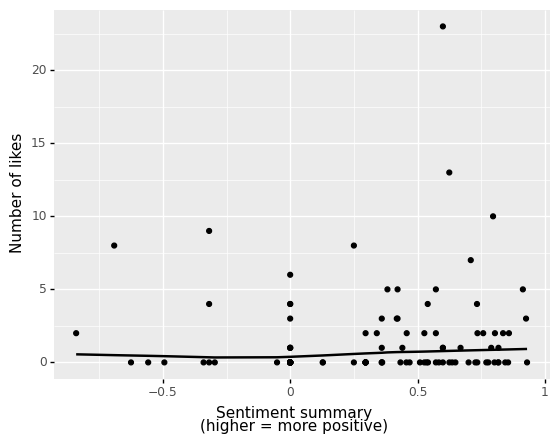

<ggplot: (8774596189687)>

In [24]:
## no clear relationship
(ggplot(m_tweets_df, aes(x = 'compound_sent', y = 'public_metrics')) +
geom_point() +
xlab("Sentiment summary\n(higher = more positive)") +
ylab("Number of likes") +
geom_smooth())


# Activity for your practice

1. Choose a public user (e.g., a politician; celebrity) and pull 100 tweets from their timeline and metadata about those tweets. When pulling metadata, make sure to get the conversation_id and count of replies (latter is in public_metrics)
2. Choose one of their tweets to focus on that got a lot of replies and get the conversation_id of that tweet
3. Paste the conversation id of that tweet into a query using this documentation for query building: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query#examples
4. Similar to example 1.1 in the example code, use the `search_recent_tweets` method to pull tweets that are in response to the focal tweet from step 2--- note, if there are no public replies, this may return None; therefore, make sure to choose a tweet with 20+ replies
5. Place them in a dataframe and views the results

In [25]:
## focal user: MayorBowser

### step 1: get numeric id
mmb_id = client.get_user(username= "MayorBowser").data['id']

### step 2: pull max 100 tweets
tweet_attr = ['id',
              'created_at', 'author_id', 
             'text', 'lang', 'geo',
             'conversation_id', 'public_metrics']
mmb_t_resp = client.get_users_tweets(id = mmb_id,
                max_results = 100, 
                tweet_fields = tweet_attr,
                exclude = 'retweets')

print(type(mmb_t_resp))

one_tweet = mmb_t_resp.data[0]
one_tweet['public_metrics']

### step 3: clean up; this time, i want to get all the diff engagement metrics
### so i'm modifying the function
### function to iterate over attributes
def pull_attr_flat(one_tweet, which_attr):
    all_attr = [one_tweet[attr]   
                for attr in which_attr]
    return(all_attr)

def pull_attr_nested(one_tweet, attr = 'public_metrics'):
    all_attr_vals = [value[1] for value in
                    one_tweet[attr].items()]
    return all_attr_vals

tweet_att_1 = pd.DataFrame([pull_attr_flat(one_tweet,
                [att for att in tweet_attr if att != "public_metrics"]) 
                for one_tweet in mmb_t_resp.data],
                columns = [att
                for att in tweet_attr if att != "public_metrics"])

tweet_att_2 = pd.DataFrame([pull_attr_nested(one_tweet) 
                for one_tweet in mmb_t_resp.data],
                columns = [key[0] 
                for key in mmb_t_resp.data[0]['public_metrics'].items()])

## combine
mmb_tweet_att = pd.concat([tweet_att_1, tweet_att_2], axis = 1)
mmb_tweet_att.sort_values(by = 'reply_count', ascending = False).head()
mmb_tweet_att.sort_values(by = 'reply_count', ascending = False).tail()

<class 'tweepy.client.Response'>


{'retweet_count': 7, 'reply_count': 1, 'like_count': 13, 'quote_count': 0}

,id,created_at,author_id,text,lang,geo,conversation_id,retweet_count,reply_count,like_count,quote_count
24,1585402162665897986,2022-10-26 22:45:05+00:00,976542720,"Thank you to everyone who helped make the 35th Annual 17th Street High Heel Race a success! Whether you raced 👠, cheered 🎉, or just came out to support our LGBTQ+ community 🏳️‍🌈🏳️‍⚧️, you made it a night to remember! https://t.co/NiviV8mUxj",en,None,1585402162665897986,15,30,98,7
80,1582446121237946369,2022-10-18 18:58:50+00:00,976542720,"Join me for the 35th Annual 17th Street High Heel Race! 👠\n\nThis is a DC tradition you don't want to miss, featuring local drag entertainment, a parade, and much more! \n\n🗓 Tuesday Oct. 25\n⏰ 5pm\n📍17t St. NW\n\nRSVP ⬇️\n\nhttps://t.co/LBZbawEiEc",en,None,1582446121237946369,23,7,34,3
47,1584243272796737536,2022-10-23 18:00:04+00:00,976542720,"Get ready DC! Our 35th Annual 17th Street High Heel Race is right around the corner. 👠\n\nThis is a DC tradition you don't want to miss, featuring local drag entertainment, a parade, and much more!\n\n🗓 Tuesday Oct. 25\n⏰ 5pm\n📍17t St. NW\n\nRSVP ⬇️\nhttps://t.co/agzOK7VOt6",en,None,1584243272796737536,11,6,28,0
32,1584852099216551937,2022-10-25 10:19:20+00:00,976542720,"Combining grace, elegance, and longevity, Ms.Vanilla Beane embodied Black excellence. Today, we send our love and prayers to Ms. Beane’s family and all who will miss her. https://t.co/hK5qDCQvLo",en,None,1584852099216551937,29,6,98,7
68,1583081864566145024,2022-10-20 13:05:03+00:00,976542720,Happy Birthday Madam Vice President @KamalaHarris 🥳 https://t.co/P5L2WRp1IZ,en,None,1583081864566145024,15,5,86,0


,id,created_at,author_id,text,lang,geo,conversation_id,retweet_count,reply_count,like_count,quote_count
38,1584578365809659905,2022-10-24 16:11:37+00:00,976542720,"Additionally, starting November 6, most pumpkins and gourds can be taken to one of nine food waste collection sites for composting. Find a site near you: https://t.co/oIpmQNbANB",en,None,1584578291222351878,6,0,14,2
36,1584656351955144705,2022-10-24 21:21:30+00:00,976542720,"We are #DCProud to have organizations like @halcyonincubate in our city. When it comes to supporting innovation, we are right there with you. \n\nLet’s keep DC a place where people come to change the world and congratulations to all of the award recipients. https://t.co/DeZuHvZ9iy",en,None,1584656351955144705,4,0,19,0
34,1584833399927312385,2022-10-25 09:05:01+00:00,976542720,Here are today's Test Yourself Express At-Home Rapid Antigen Test pickup sites. https://t.co/XxqckEGMzF,en,None,1584833399927312385,12,0,13,1
29,1585194561063845889,2022-10-26 09:00:09+00:00,976542720,"Today’s walk-up vaccination &amp; PCR testing sites.\n\nBoosters available for eligible people 5+ at all sites.\n\nFor at-home vaccination appointments, call 1-855-363-0333.\n\nFind more vaccine access points at https://t.co/rP2UX7RU99\nPre-register for testing at https://t.co/gwfNlT3pPj https://t.co/7baQBZjczj",en,None,1585194561063845889,7,0,9,1
77,1582659072226009089,2022-10-19 09:05:01+00:00,976542720,Here are today's Test Yourself Express At-Home Rapid Antigen Test pickup sites. https://t.co/vj3x1yJo7t,en,None,1582659072226009089,10,0,12,1


In [26]:
## use query function to pull some replies
### step 1: get conversation id
focal_convo = '1585402162665897986'

### step 2: write query to pull tweets w/ that convo id
query = "conversation_id:{}".format(focal_convo)
query


'conversation_id:1585402162665897986'

In [27]:
### step 3: search based on query
tweets_resp = client.search_recent_tweets(query = query, max_results = 100,
                                    tweet_fields = ['created_at',
                                                    'author_id',
                                                   'geo',
                                                   'lang', 
                                                   'public_metrics'],
                                    user_fields = ['description',
                                                  'location',
                                                  'verified',
                                                  'public_metrics'],
                                    expansions = 'author_id')

tweets_resp_df = pd.DataFrame([pull_attr_flat(one_tweet,
                [att for att in tweet_attr if att != "public_metrics"]) 
                for one_tweet in tweets_resp.data],
                columns = [att for att in tweet_attr if att != "public_metrics"])
tweets_resp_df.head()

,id,created_at,author_id,text,lang,geo,conversation_id
0,1586008704050077698,2022-10-28 14:55:16+00:00,1511966390420312065,@MayorBowser @SwoleDogeChain $SDC\nSubsciption on PinkSale\n\n✅Dapp LIVE\n✅Badge SAFU\n✅Testnet ready\nJoin:https://t.co/wHsrKByWjz\n✅AMA\nCoinTV\nPinksale\nVenom\nCaesar\n✅Mainnet launched after the $SDC listing\n✅Tax:1%\n⏰14:00UTC 28/10\nLink:https://t.co/1uUfdO7GSZ\n\nhttps://t.co/DOQGkBh4uu #16496,en,None,None
1,1585978901188481024,2022-10-28 12:56:50+00:00,786567477950025728,@MayorBowser @JulieCR46 Please help me madam im physical handicapped person poor family India,en,None,None
2,1585706355674910720,2022-10-27 18:53:50+00:00,253740939,@MayorBowser Fiddle while citizens kill each other. Wise up.,en,None,None
3,1585692964973645824,2022-10-27 18:00:38+00:00,2165996872,@NatHokie @abigailmarone @MayorBowser Lol a Virginia resident,en,None,None
4,1585692846153138192,2022-10-27 18:00:09+00:00,2165996872,@MayorBowser Who cares about violent crime!,en,None,None
